Install all needed libraries

In [4]:
%pip install pandas
%pip install scikit-learn
%pip install joblib
%pip install matplotlib
%pip install nltk
%pip install transformers
%pip install datasets
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3.12 in

Data Cleaning and Preprocessing:


*   Load dataset (https://www.kaggle.com/datasets/abdallahwagih/books-dataset?resource=download)
*   Remove rows where description and category is not given
*   Keep only the first genre if multiple are present
*   Keep the most frequent genres only
*   Split the dataset into training and test set
*   Vectorize using TF-IDF



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
import torch
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments


from nltk.corpus import stopwords
nltk.download('stopwords')

df = pd.read_csv("data.csv")
df_clean = df.dropna(subset=["description", "categories"]).copy()
df_clean["main_category"] = df_clean["categories"].apply(lambda x: x.split(";")[0].strip())

# leave top 10 most frequent genres
top_categories = df_clean["main_category"].value_counts().nlargest(10).index.tolist()
df_top10 = df_clean[df_clean["main_category"].isin(top_categories)]

# prepare features (X) and labels (y)
X = df_top10["description"]
y = df_top10["main_category"]

# encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# training 80% and test 20% sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# vectorize descriptions
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000, sublinear_tf=True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasiyadamaratskaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Models Training and Accuracy Computing

In [9]:
# Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)
y_pred_nb = model_nb.predict(X_test_vec)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Support Vector Machine (SVM)
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

Naive Bayes Accuracy: 0.5737704918032787
Logistic Regression Accuracy: 0.6524590163934426
Random Forest Accuracy: 0.6546448087431694
SVM Accuracy: 0.7114754098360656


Training transformers

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

# convert text and labels to list
train_texts = X_train.tolist()
test_texts = X_test.tolist()
train_labels = y_train.tolist()
test_labels = y_test.tolist()

# DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})
num_labels = len(set(train_labels))
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted')
    }

# training configuration
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# train & evaluate
trainer.train()
eval_result = trainer.evaluate()
print("Evaluation Results:", eval_result)

# save model and tokenizer
model.save_pretrained("./book_genre_classifier_model")
tokenizer.save_pretrained("./book_genre_classifier_model")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939900,0.773942,0.772678,0.745360
2,0.620000,0.658752,0.805464,0.797041
3,0.299500,0.647001,0.824044,0.812764


Evaluation Results: {'eval_loss': 0.647001326084137, 'eval_accuracy': 0.8240437158469945, 'eval_f1': 0.8127635496506493, 'eval_runtime': 8.8231, 'eval_samples_per_second': 103.705, 'eval_steps_per_second': 13.034, 'epoch': 3.0}


('./book_genre_classifier_model/tokenizer_config.json',
 './book_genre_classifier_model/special_tokens_map.json',
 './book_genre_classifier_model/vocab.txt',
 './book_genre_classifier_model/added_tokens.json',
 './book_genre_classifier_model/tokenizer.json')

Classification Report for Naive Bayes

In [10]:
present_labels = unique_labels(y_test, y_pred_nb)
present_class_names = label_encoder.inverse_transform(present_labels)

report = classification_report(
    y_test, y_pred_nb,
    labels=present_labels,
    target_names=present_class_names,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()
top_f1 = report_df.sort_values(by="f1-score", ascending=False).head(10)

print("\nTop 10 genres by F1-score (Naive Bayes):")
print(top_f1)


Top 10 genres by F1-score (Naive Bayes):
                           precision    recall  f1-score    support
Fiction                     0.570796  1.000000  0.726761  516.00000
accuracy                    0.573770  0.573770  0.573770    0.57377
weighted avg                0.505498  0.573770  0.428274  915.00000
Literary Criticism          1.000000  0.120000  0.214286   25.00000
macro avg                   0.437080  0.122607  0.114524  915.00000
Juvenile Fiction            0.800000  0.038095  0.072727  105.00000
Religion                    1.000000  0.035714  0.068966   28.00000
Philosophy                  1.000000  0.032258  0.062500   31.00000
Biography & Autobiography   0.000000  0.000000  0.000000   86.00000
Comics & Graphic Novels     0.000000  0.000000  0.000000   22.00000


Confusion Matrix for Naive Bayes

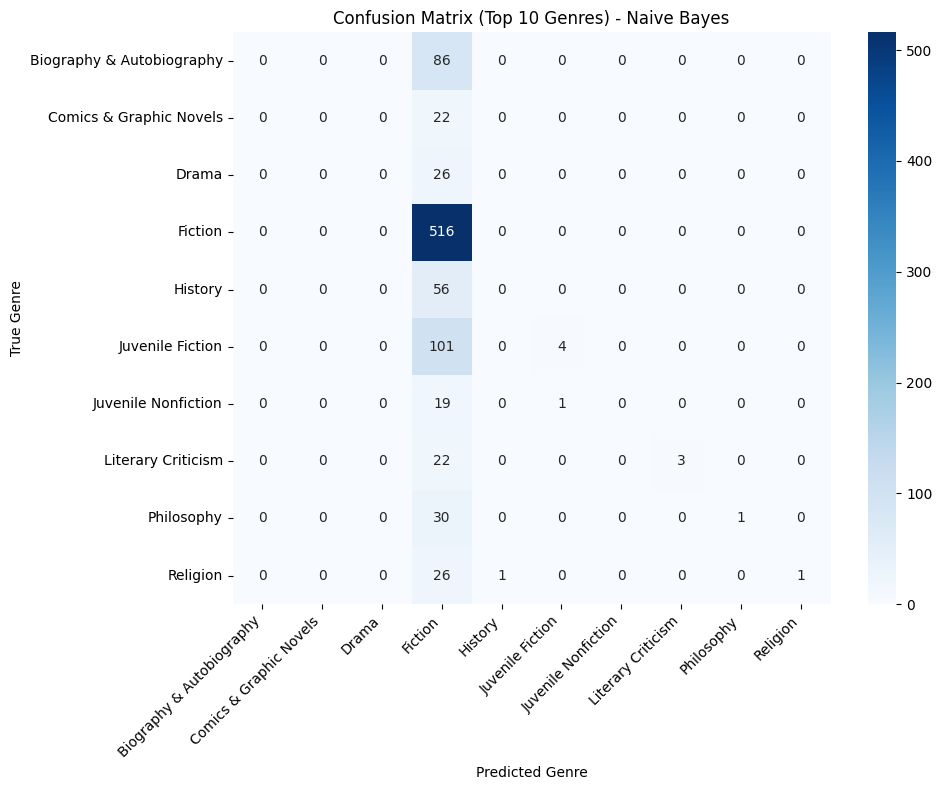

In [11]:
cm = confusion_matrix(y_test, y_pred_nb, labels=present_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_class_names,
            yticklabels=present_class_names)
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.title("Confusion Matrix (Top 10 Genres) - Naive Bayes")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

F1-score Comparison


F1-score (weighted) for all models:
Naive Bayes: 0.4283
Logistic Regression: 0.5795
Random Forest: 0.5908
SVM: 0.6823
DistilBERT: 0.8128
Best model based on weighted F1-score: DistilBERT (0.8128)


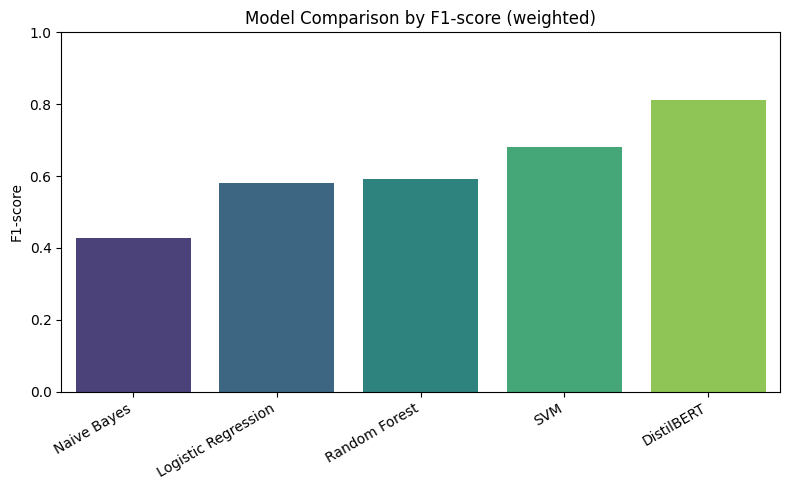

All models and preprocessing objects saved successfully.


In [14]:
f1_scores = {
    "Naive Bayes": f1_score(y_test, y_pred_nb, average="weighted", zero_division=0),
    "Logistic Regression": f1_score(y_test, y_pred_lr, average="weighted", zero_division=0),
    "Random Forest": f1_score(y_test, y_pred_rf, average="weighted", zero_division=0),
    "SVM": f1_score(y_test, y_pred_svm, average="weighted", zero_division=0),
    "DistilBERT" : eval_result.get("eval_f1")
}
# Print F1-scores
print("\nF1-score (weighted) for all models:")
for model_name, score in f1_scores.items():
    print(f"{model_name}: {score:.4f}")

# Find the best model
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_model_name]
print(f"Best model based on weighted F1-score: {best_model_name} ({best_f1_score:.4f})")

model_names = list(f1_scores.keys())
f1_vals = list(f1_scores.values())

# Plot F1-score comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=f1_vals, hue=model_names, palette="viridis", legend=False)
plt.title("Model Comparison by F1-score (weighted)")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# === Save all models and encoders ===
joblib.dump(model_nb, "genre_classifier_nb.pkl")
joblib.dump(log_reg, "genre_classifier_logreg.pkl")
joblib.dump(rf_model, "genre_classifier_rf.pkl")
joblib.dump(svm_model, "genre_classifier_svm.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("All models and preprocessing objects saved successfully.")